# MLOps Project

<video controls width="640" height="360">
  <source src="/Users/josereyes/Downloads/presentation.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

In [ ]:
# install packages
!pip install dill
!pip install scikit-learn

     |████████████████████████████████| 119 kB 3.9 MB/s eta 0:00:01


# Imports

In [4]:
import numpy as np
import pandas as pd

import sklearn

import sqlite3
import os
from sklearn.datasets import load_breast_cancer
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

import dill

In [6]:
# change settings
sklearn.set_config(transform_output='pandas')


TypeError: set_config() got an unexpected keyword argument 'transform_output'

# Step 1: Create Normalized Database

**SQL**

1 NF:

- Each cell contains a single basic value
- No repeating array or groups of data eg strings with data seperated by commas
- Each pk is unique

2 NF:
- Primary key describes the row

3 NF:
- No transitive relationships ie features cant have a relationship with each other


Have 3 tables

Diagnosis: DiagnosisID, DiagnoisCode, Diagnosis, Diagnosis Description

Diagnosis Description: DiagnosisDescriptionID, DiagnosisDescription

CellNucleiFeatures: NucleiID, PatientID, DiagnosisID, nuclei features


In [ ]:
# parse file
data = []
with open('breast-cancer.csv') as file:
  header = None
  for line in file:
    line = line.strip()
    if line == '':
      continue
    elif header == None:
      header = line
      continue

    row_vals = line.split(',')
    row_vals[0] = int(row_vals[0])
    for i in range(2,len(row_vals)):
      row_vals[i] = float(row_vals[i])
    data.append(row_vals)
header = header.split(',')

#pd.DataFrame(data,columns=header)
#df.info()



In [ ]:
# create tables
if os.path.exists('normalized.db'):
  os.remove('normalized.db')
# connection -> sql statement -> cursor -> execute
conn = sqlite3.connect('normalized.db')
create_diagnosis_table = '''
CREATE TABLE Diagnosis
(
  DiagnosisID     INTEGER         NOT NULL PRIMARY KEY,
  DiagnosisCode     text         NOT NULL,
  Diagnosis     text         NOT NULL,
  DiagnosisDescription     text         NOT NULL
); '''


create_cell_nuclei_table = '''
CREATE TABLE CellNucleiFeatures
(
  CellNucleiID    INTEGER      NOT NULL PRIMARY KEY,
  PatientID       INTEGER      NOT NULL,
  DiagnosisID     TEXT         NOT NULL,
  radius_mean     REAL         NOT NULL,
  texture_mean     REAL         NOT NULL,
  perimeter_mean     REAL         NOT NULL,
  area_mean     REAL         NOT NULL,
  smoothness_mean     REAL         NOT NULL,
  compactness_mean     REAL         NOT NULL,
  concavity_mean     REAL         NOT NULL,
  concave_points_mean     REAL         NOT NULL,
  symmetry_mean     REAL         NOT NULL,
  fractal_dimension_mean     REAL         NOT NULL,
  radius_se     REAL         NOT NULL,
  texture_se     REAL         NOT NULL,
  perimeter_se     REAL         NOT NULL,
  area_se     REAL         NOT NULL,
  smoothness_se     REAL         NOT NULL,
  compactness_se     REAL         NOT NULL,
  concavity_se     REAL         NOT NULL,
  concave_points_se     REAL         NOT NULL,
  symmetry_se     REAL         NOT NULL,
  fractal_dimension_se     REAL         NOT NULL,
  radius_worst     REAL         NOT NULL,
  texture_worst     REAL         NOT NULL,
  perimeter_worst     REAL         NOT NULL,
  area_worst     REAL         NOT NULL,
  smoothness_worst     REAL         NOT NULL,
  compactness_worst     REAL         NOT NULL,
  concavity_worst     REAL         NOT NULL,
  concave_points_worst     REAL         NOT NULL,
  symmetry_worst     REAL         NOT NULL,
  fractal_dimension_worst     REAL         NOT NULL,
  FOREIGN KEY (DiagnosisID) REFERENCES Diagnosis (DiagnosisID)
); '''

cur = conn.cursor()
cur.execute(create_diagnosis_table)
cur.execute(create_cell_nuclei_table)

In [ ]:
# use this for nuc descr


#Features are computed from a digitized image of a fine needle
#aspirate (FNA) of a breast mass.  They describe
#characteristics of the cell nuclei present in the image.
breast_data = load_breast_cancer(as_frame=True)
breast_data.data.columns
print(breast_data['DESCR'])

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [ ]:
# create insert statements
diagnosis_insert = ''' INSERT INTO Diagnosis(DiagnosisID,DiagnosisCode,Diagnosis,DiagnosisDescription)
          VALUES(?,?,?,?) '''
cell_nuclei_features_insert = ''' INSERT INTO CellNucleiFeatures(PatientID,DiagnosisID,
 radius_mean,
 texture_mean,
 perimeter_mean,
 area_mean,
 smoothness_mean,
 compactness_mean,
 concavity_mean,
 concave_points_mean,
 symmetry_mean,
 fractal_dimension_mean,
 radius_se,
 texture_se,
 perimeter_se,
 area_se,
 smoothness_se,
 compactness_se,
 concavity_se,
 concave_points_se,
 symmetry_se,
 fractal_dimension_se,
 radius_worst,
 texture_worst,
 perimeter_worst,
 area_worst,
 smoothness_worst,
 compactness_worst,
 concavity_worst,
 concave_points_worst,
 symmetry_worst,
 fractal_dimension_worst)
          VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''


In [ ]:
# create data for diagnosis table and insert
diagnosis_data = [[ 0,'B', 'Benign','Patient tested negative.'],[1,'M','Malignant','Patient tested positive.']]
with conn:
  cur.executemany(diagnosis_insert, diagnosis_data)

In [ ]:
# get data for cell nuclei table and insert
cell_nuclei_data = []

for ele in data:
  row_vals = [ele[0]]
  if ele[1] == 'B':
    row_vals.append(0)
  else:
    row_vals.append(1)
  row_vals.extend(ele[2:])
  cell_nuclei_data.append(row_vals)

with conn:
  cur.executemany(cell_nuclei_features_insert, cell_nuclei_data)

# Step 2: SQL join statement to fetch data from the database and place into dataframe

In [ ]:
# create SQL join statement to fetch data from the database and place into dataframe

sql_join = '''
select
  cn.PatientID,
  d.DiagnosisCode,
  cn.radius_mean,
  cn.texture_mean,
  cn.perimeter_mean,
  cn.area_mean,
  cn.smoothness_mean,
  cn.compactness_mean,
  cn.concavity_mean,
  cn.concave_points_mean,
  cn.symmetry_mean,
  cn.fractal_dimension_mean,
  cn.radius_se,
  cn.texture_se,
  cn.perimeter_se,
  cn.area_se,
  cn.smoothness_se,
  cn.compactness_se,
  cn.concavity_se,
  cn.concave_points_se,
  cn.symmetry_se,
  cn.fractal_dimension_se,
  cn.radius_worst,
  cn.texture_worst,
  cn.perimeter_worst,
  cn.area_worst,
  cn.smoothness_worst,
  cn.compactness_worst,
  cn.concavity_worst,
  cn.concave_points_worst,
  cn.symmetry_worst,
  cn.fractal_dimension_worst
from
  CellNucleiFeatures as cn
inner join
  Diagnosis as d
on
  cn.DiagnosisID = d.DiagnosisID
'''
cur.execute(sql_join)
data = cur.fetchall()

df = pd.DataFrame(data=data,columns=header)
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
df.set_index('id',inplace=True,drop=True)
X = df.drop('diagnosis',axis = 1)
y = df['diagnosis']

# Step 3: Explore data to identify potential need for stratification

In [ ]:
y.value_counts()

,count
diagnosis,
B,357
M,212


There are only 212 instance that are malignant. Stratify based on diagnosis to avoid risk of having too few malignant instances in the training or test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=0,stratify=y,shuffle=True)
print('Full Dataset')
diagnosis_percentage = round(100 *y.value_counts() / len(y),2)
diagnosis_percentage.name = 'percentage (%)'
diagnosis_percentage
print('')
print('Training Dataset')
diagnosis_percentage_train = round(100 *y_train.value_counts() / len(y_train),2)
diagnosis_percentage_train.name = 'percentage (%)'
diagnosis_percentage_train
print('')
print('Test Dataset')
diagnosis_percentage_test = round(100 *y_test.value_counts() / len(y_test),2)
diagnosis_percentage_test.name = 'percentage (%)'
diagnosis_percentage_test

Full Dataset


,percentage (%)
diagnosis,
B,62.74
M,37.26



Training Dataset


,percentage (%)
diagnosis,
B,62.64
M,37.36



Test Dataset


,percentage (%)
diagnosis,
B,63.16
M,36.84


# Step 4: Explore data using yprofile and correlation matrix

In [ ]:
#ydata_profiling.ProfileReport(X_train)

<Figure size 1800x1300 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

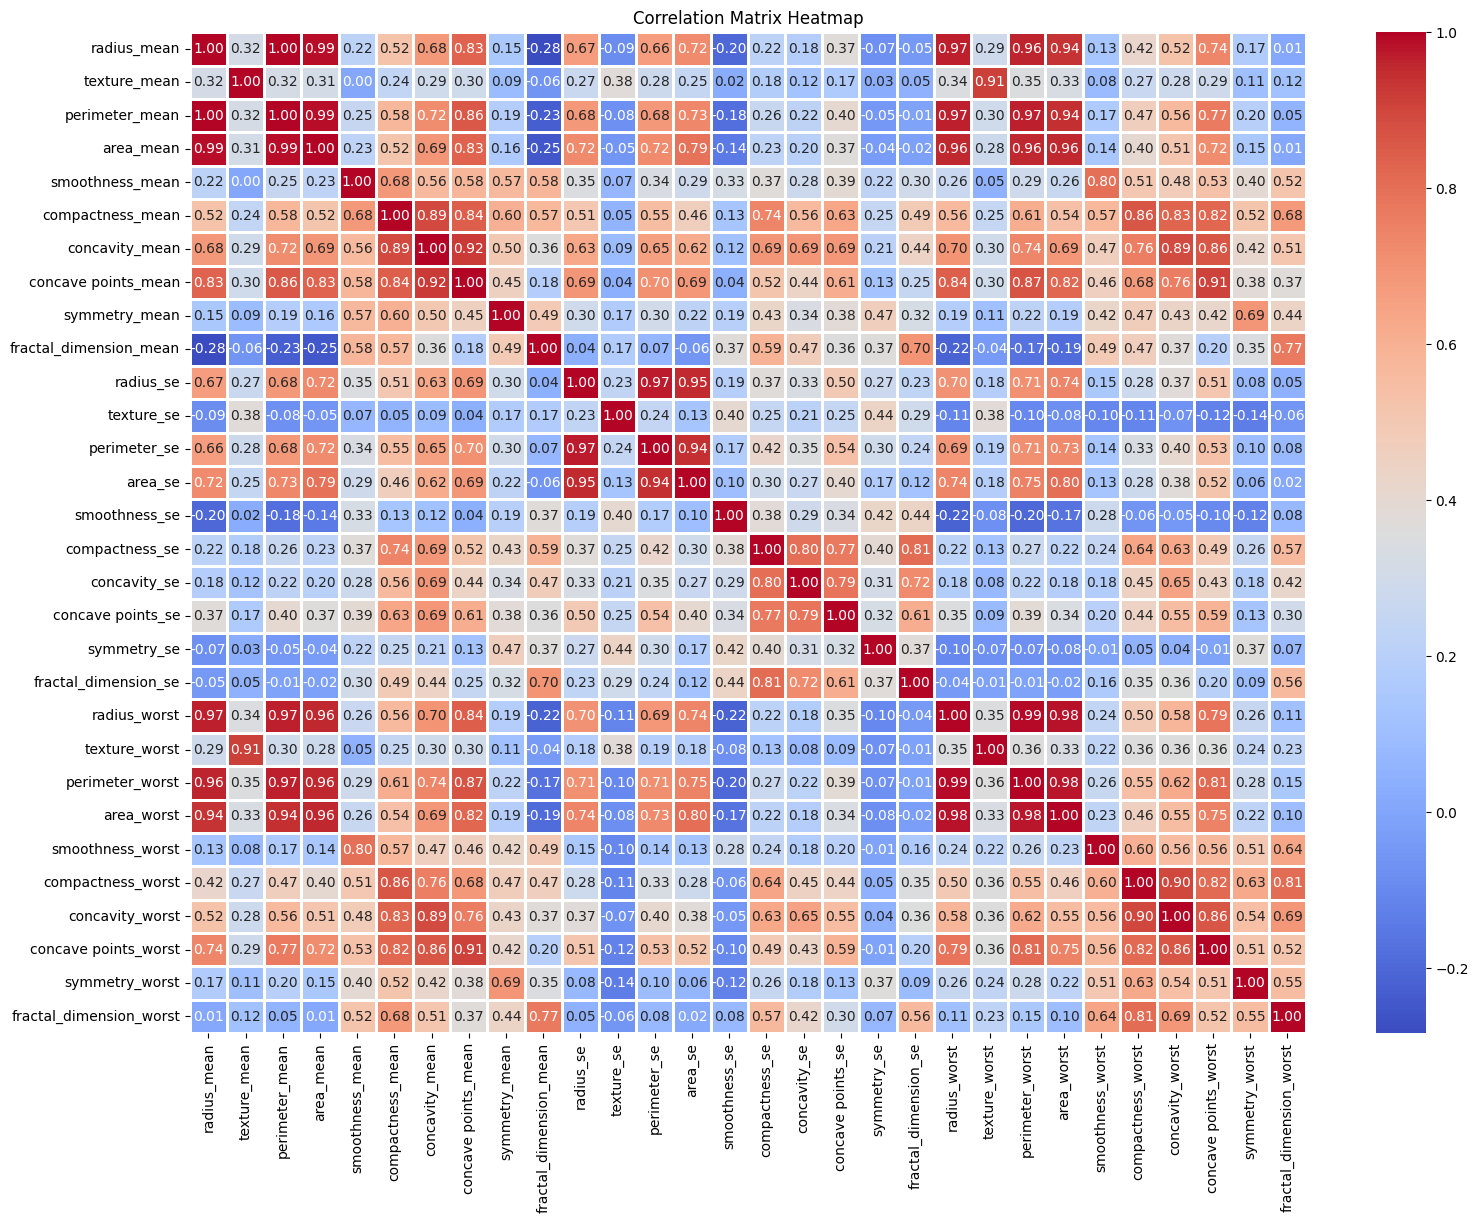

In [ ]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(18, 13))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

Data cleanup tasks:
1. Set the dataframe's index to patient id and remove it from the set of columns.

2. Change the target's values from text data type to integer data type. In accordance with standard convention, let 1 represent the more interesting class, which in this case is malignant.

In [ ]:
y_train.replace(['B','M'],[0,1],inplace=True)
y_test.replace(['B','M'],[0,1],inplace=True)

<ipython-input-16-234d707f60a0>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train.replace(['B','M'],[0,1],inplace=True)
<ipython-input-16-234d707f60a0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test.replace(['B','M'],[0,1],inplace=True)


# Step 5: Experiment #1

In [ ]:
pd.set_option('display.max_columns', 40)
log_columns = X_train.columns[X_train.describe().loc['min'] > 0]
log_columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
log_transformer = FunctionTransformer(np.log)
pipeline = Pipeline([
    ('log',log_transformer),
    ('scale',StandardScaler())
])

preprocessing = ColumnTransformer([
    ('pipeline',pipeline,log_columns)
],remainder=StandardScaler())

lr_pipeline = Pipeline([
    ('preprocessing',preprocessing),
    ('log_reg',LogisticRegression(random_state=0,solver='liblinear'))
])

In [ ]:
hyperparameters = [
    {'log_reg__penalty' : ['l1'],
     'log_reg__C' : [.1, 1, 10]},
    {'log_reg__penalty' : ['l2'],
     'log_reg__C' : [.1, 1, 10]}
]
grid_search = GridSearchCV(lr_pipeline,param_grid=hyperparameters,cv=3,scoring='f1')
grid_search.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log'>)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'symmetry_mean',
       'fractal...
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object'))])),
                                       ('log_reg',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             param_grid=[{'log_reg__C': [0.1, 1, 10],
                          'log_reg__penalty': ['l1']},
                         {'log_reg__C': [0.1, 1, 10],
                          'log_reg__penalty': ['l2']}],
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_).iloc[:,4:]
cv_results.sort_values('mean_test_score',inplace=True,ascending=False)
cv_results.reset_index(drop=True,inplace=True)
cv_results.drop('params',axis=1,inplace=True)
cv_results.iloc[:,2:-1] = cv_results.iloc[:,2:-1].round(3)
cv_results.columns = [ 'Regularization Strength (C)','Regularization Type','f1 score: split 1','f1 score: split 2','f1 score: split 3','f1 score: mean','f1 score: std','rank']
print('Grid Search Results')
cv_results

Grid Search Results


,Regularization Strength (C),Regularization Type,f1 score: split 1,f1 score: split 2,f1 score: split 3,f1 score: mean,f1 score: std,rank
0,0.1,l2,0.991,0.974,0.964,0.976,0.011,1
1,1.0,l2,0.982,0.974,0.954,0.970,0.012,2
2,1.0,l1,0.982,0.974,0.945,0.967,0.016,3
3,0.1,l1,0.974,0.966,0.945,0.962,0.012,4
4,10.0,l2,0.955,0.983,0.929,0.955,0.022,5
5,10.0,l1,0.964,0.966,0.912,0.948,0.025,6


In [ ]:
dagshub_log_1_scores = cv_results.iloc[0,:].to_dict()
dagshub_log_1_hyperparameters = {}
dagshub_log_1_hyperparameters['regularization_strength_C'] = .1
dagshub_log_1_hyperparameters['regularization_type'] = 'l2'
dagshub_log_1_scores.pop('Regularization Strength (C)')
dagshub_log_1_scores.pop('Regularization Type')
dagshub_log_1_scores.pop('rank')
dagshub_log_1_scores

0.1

'l2'

1

{'f1 score: split 1': 0.991,
 'f1 score: split 2': 0.974,
 'f1 score: split 3': 0.964,
 'f1 score: mean': 0.976,
 'f1 score: std': 0.011}

In [ ]:
dagshub_log_1_scores

{'f1 score: split 1': 0.991,
 'f1 score: split 2': 0.974,
 'f1 score: split 3': 0.964,
 'f1 score: mean': 0.976,
 'f1 score: std': 0.011}

In [ ]:
dagshub_log_1_hyperparameters

{'regularization_strength_C': 0.1, 'regularization_type': 'l2'}

# Step : Save final model using joblib

In [ ]:
# to save final model
final_model = grid_search.best_estimator_
with open('final_model.pkl','wb') as f:
  dill.dump(final_model,f)

In [ ]:
# to load final model
with open('final_model.pkl','rb') as f:
  final_model_loaded = dill.load(f)


In [ ]:
#final_model_loaded.get_params()
final_model_loaded.score(X_test,y_test)

0.9385964912280702

In [ ]:
final_model.score(X_test,y_test)

0.9385964912280702

In [ ]:
X_train.columns.shape

(30,)

In [ ]:
!pip install requests

In [ ]:
import requests
import json

In [ ]:
row = X_train.iloc[0,:]
data = json.dumps(row.to_dict(), indent=2)
r = requests.post('http://127.0.0.1:8000/predict',data=data)
r.json()

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7b2e923efb80>: Failed to establish a new connection: [Errno 111] Connection refused'))